In [ ]:
!apt-get install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


## **Carregando os dados**

In [ ]:
# Importando bibliotecas necessárias
import numpy as np
import pandas as pd
from google.colab import files
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Fazer upload do arquivo ARFF
uploaded = files.upload()

# O nome do arquivo é a chave no dicionário uploaded
filename = next(iter(uploaded))

# Carregar o arquivo ARFF
data, meta = arff.loadarff(filename)

# Converter para DataFrame do pandas
df = pd.DataFrame(data)

# Exibir os primeiros registros do DataFrame
print(df.head())


# Verificar se há colunas com valores em bytes e convertê-las para string
for col in df.columns:
    if df[col].dtype == 'object':  # Verificando colunas que contêm bytes
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Identificar as colunas de atributos (X) e a coluna de classe (y)
X = df.iloc[:, :-1]  # Todas as colunas exceto a última (atributos)
y = df.iloc[:, -1]  # Última coluna (classe)

# Verificar os tipos de dados para identificar colunas numéricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exibir os dados numéricos antes da transformação
print("Dados numéricos antes da transformação:")
print(X[numerical_cols].head())

# Transformar colunas numéricas em categorias utilizando binning
for col in numerical_cols:
    # Aplicar pd.cut para discretização em 4 categorias (bins)
    X[col] = pd.cut(X[col], bins=4, labels=['Muito Baixo', 'Baixo', 'Alto', 'Muito Alto'])

# Exibir os dados após a transformação
print("\nDados após a transformação para categóricos:")
print(X.head())

# Aplicar Label Encoding nas novas colunas categóricas
label_encoder = LabelEncoder()
for col in X.columns:
    X[col] = label_encoder.fit_transform(X[col])

# Exibir os dados após Label Encoding
print("\nDados após Label Encoding:")
print(X.head())


Saving credit-g.arff to credit-g (5).arff
  checking_status  duration                     credit_history  \
0           b'<0'       6.0  b'critical/other existing credit'   
1     b'0<=X<200'      48.0                   b'existing paid'   
2  b'no checking'      12.0  b'critical/other existing credit'   
3           b'<0'      42.0                   b'existing paid'   
4           b'<0'      24.0              b'delayed previously'   

                  purpose  credit_amount       savings_status employment  \
0             b'radio/tv'         1169.0  b'no known savings'     b'>=7'   
1             b'radio/tv'         5951.0              b'<100'  b'1<=X<4'   
2            b'education'         2096.0              b'<100'  b'4<=X<7'   
3  b'furniture/equipment'         7882.0              b'<100'  b'4<=X<7'   
4              b'new car'         4870.0              b'<100'  b'1<=X<4'   

   installment_commitment        personal_status other_parties  ...  \
0                     4.0        

## **Árvore de Decisão com holdout sem repetição**

Acurácia do modelo de Árvore de Decisão: 68.50%


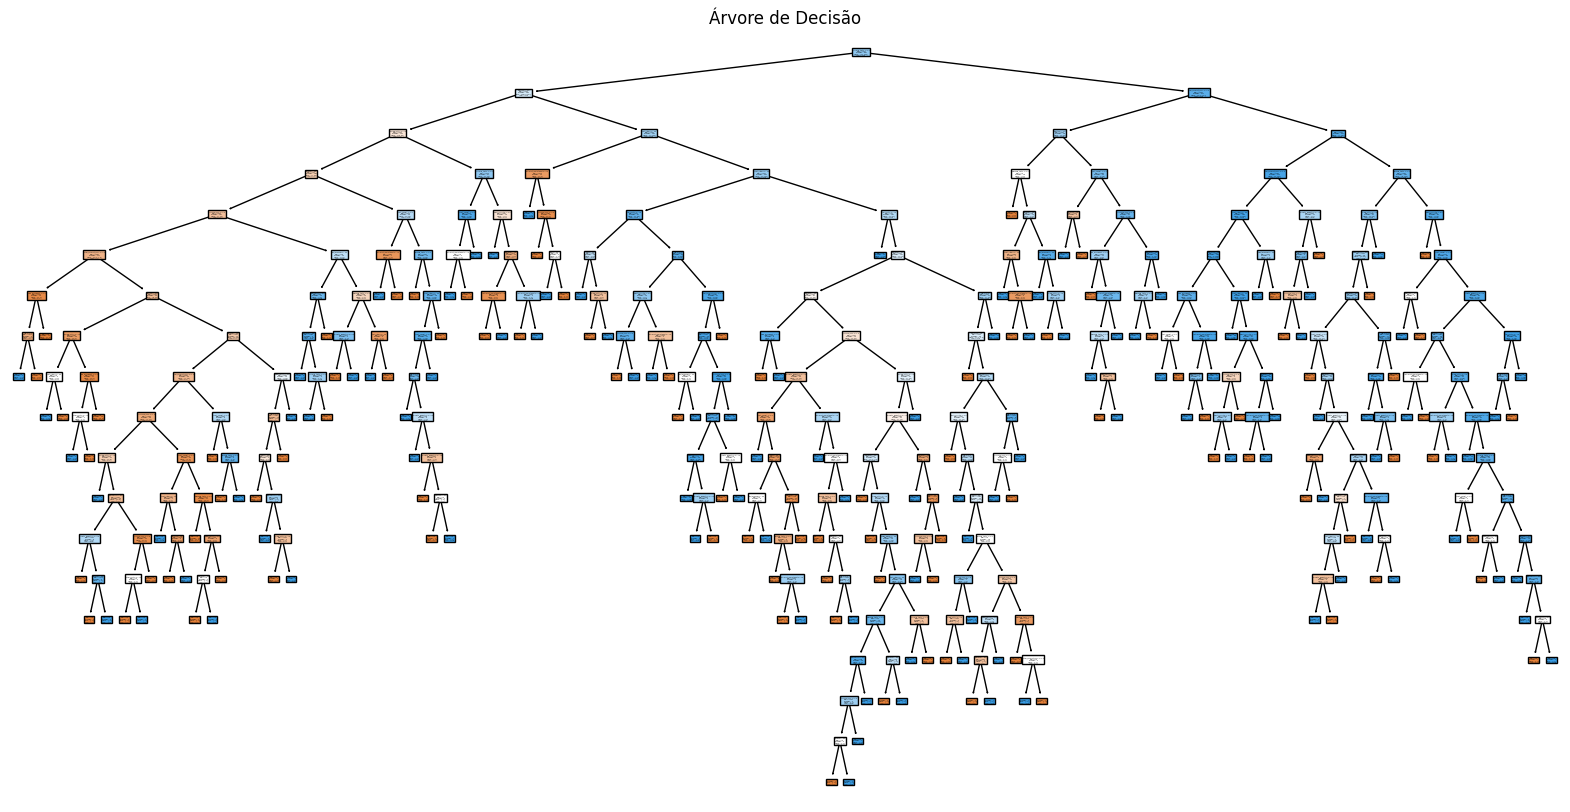

In [ ]:
# Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Ajuste random_state se necessário

# Definir o modelo de Árvore de Decisão
decision_tree = DecisionTreeClassifier()

# Treinar o modelo
decision_tree.fit(X_train, y_train)

# Fazer previsões
y_pred = decision_tree.predict(X_test)

# Avaliar a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)

# Exibir os resultados
print(f"Acurácia do modelo de Árvore de Decisão: {accuracy * 100:.2f}%")

# Visualizar a árvore de decisão
plt.figure(figsize=(20, 10))  # Ajustar o tamanho da figura conforme necessário
plot_tree(decision_tree, feature_names=df.columns[:-1], class_names=np.unique(y), filled=True)
plt.title("Árvore de Decisão")
plt.show()

## **Árvore de Decisão com holdout com repetições**

Acurácia média da Árvore de Decisão (Holdout): 67.73%
Desvio padrão da acurácia: 2.65%


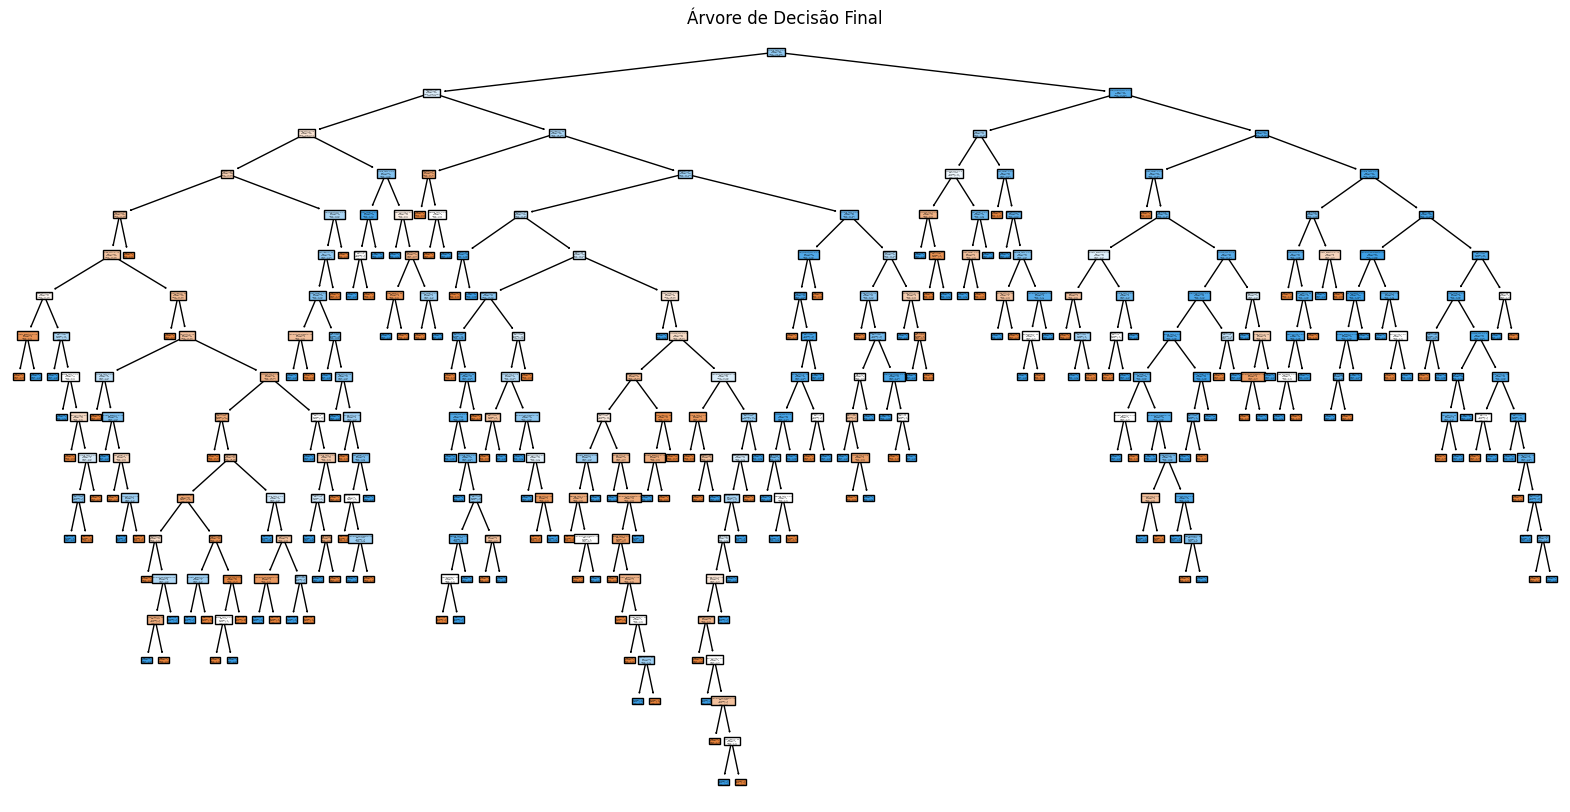

A melhor acurácia da Árvore de Decisão (Holdout): 72.50%


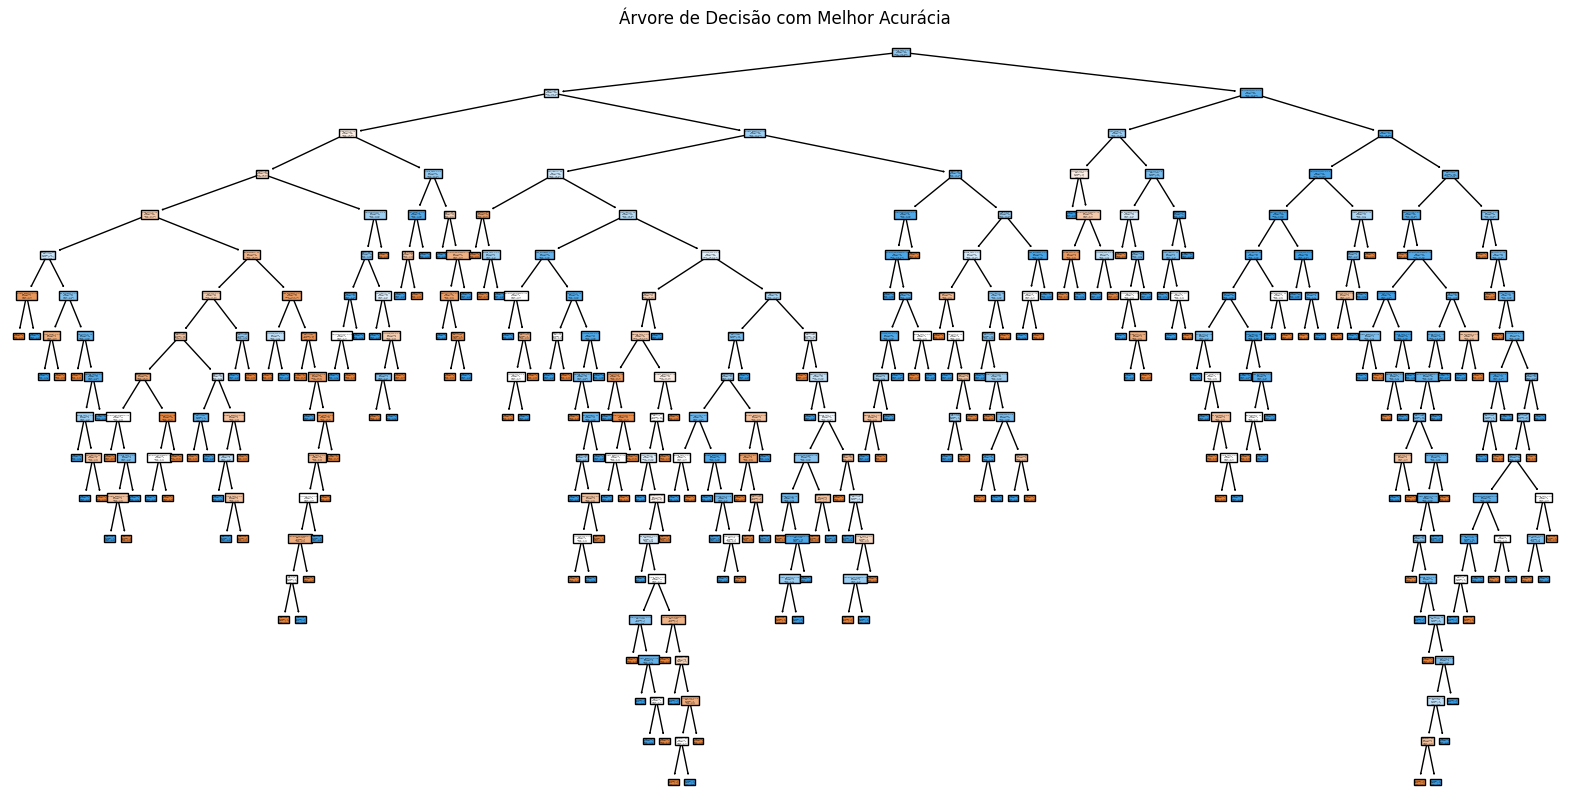

In [ ]:
# Inicializar listas para armazenar as acurácias
accuracies = []

# Inicializar variáveis para armazenar a melhor acurácia e o modelo correspondente
best_accuracy = 0
best_model = None


# Realizar Holdout com 30 repetições
for _ in range(30):
    # Dividir os dados em treino (80%) e teste (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)  # random_state=None para diferentes divisões

    # Definir o modelo de Árvore de Decisão
    decision_tree = DecisionTreeClassifier()

    # Treinar o modelo
    decision_tree.fit(X_train, y_train)

    # Fazer previsões
    y_pred = decision_tree.predict(X_test)

    # Avaliar a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

     # Verificar se a acurácia atual é a melhor
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = decision_tree  # Armazenar o modelo com a melhor acurácia

# Calcular a média e o desvio padrão das acurácias
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Exibir os resultados
print(f"Acurácia média da Árvore de Decisão (Holdout): {mean_accuracy * 100:.2f}%")
print(f"Desvio padrão da acurácia: {std_accuracy * 100:.2f}%")

# Visualizar a árvore de decisão final (após o treinamento da última árvore)
plt.figure(figsize=(20, 10))  # Ajustar o tamanho da figura conforme necessário
plot_tree(decision_tree, feature_names=df.columns[:-1], class_names=np.unique(y), filled=True)
plt.title("Árvore de Decisão Final")
plt.show()

# Exibir a melhor acurácia
print(f"A melhor acurácia da Árvore de Decisão (Holdout): {best_accuracy * 100:.2f}%")

# Visualizar a árvore de decisão com a melhor acurácia
plt.figure(figsize=(20, 10))  # Ajustar o tamanho da figura conforme necessário
plot_tree(best_model, feature_names=df.columns[:-1], class_names=np.unique(y), filled=True)
plt.title("Árvore de Decisão com Melhor Acurácia")
plt.show()


## **Árvore de Decisão com validação cruzada**

Acurácia média da Árvore de Decisão (Validação Cruzada): 68.20%
Desvio padrão da acurácia: 4.75%


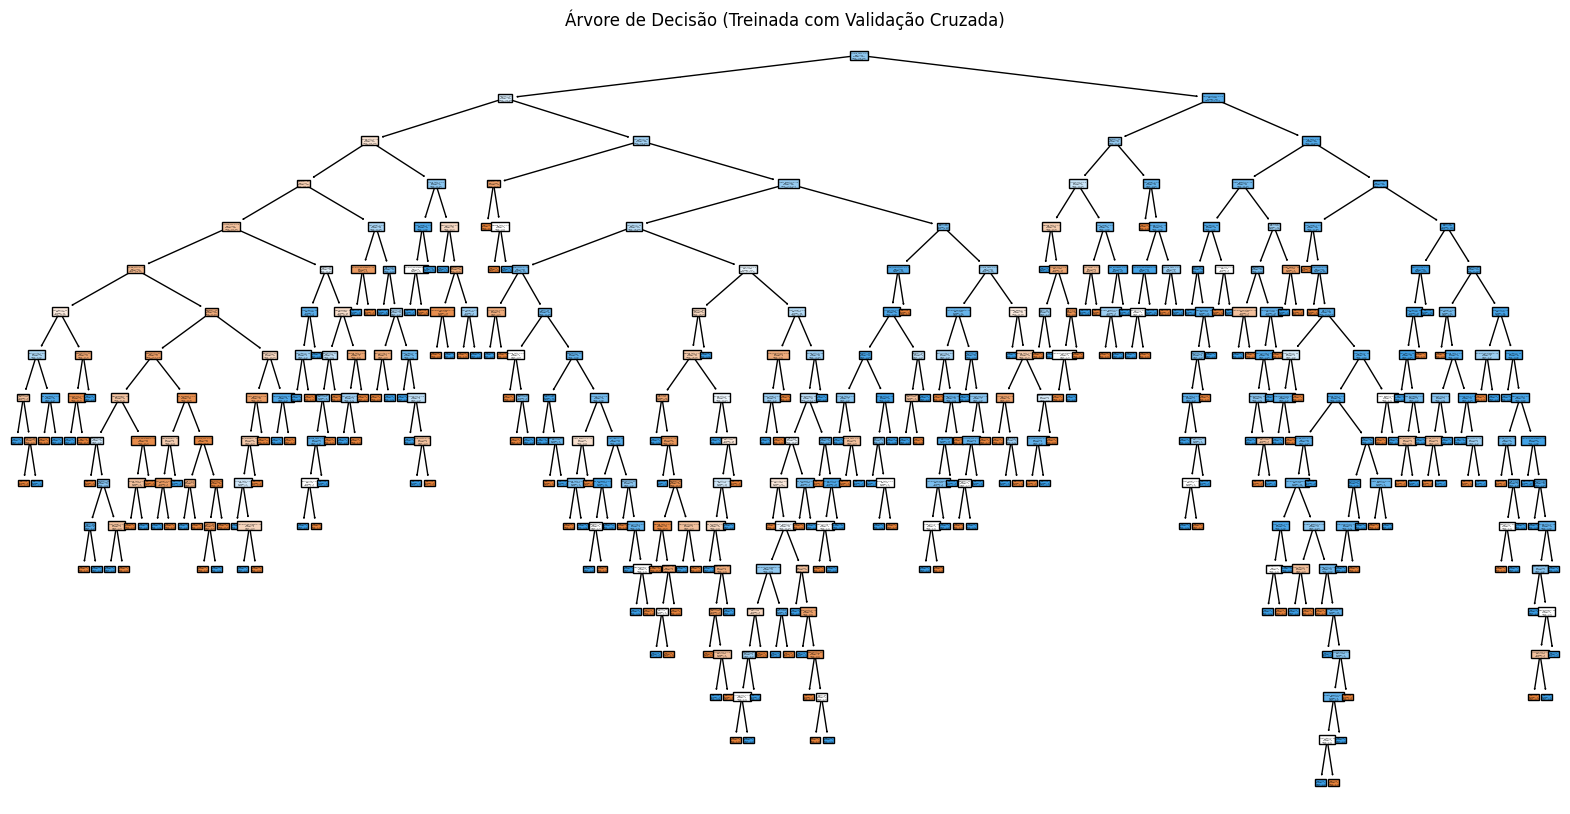

In [ ]:
# Definir o modelo de Árvore de Decisão
decision_tree = DecisionTreeClassifier()

# Realizar validação cruzada com 10 grupos
cv_scores = cross_val_score(decision_tree, X, y, cv=10)  # 10-fold cross-validation

# Calcular a média e o desvio padrão das acurácias
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

# Exibir os resultados
print(f"Acurácia média da Árvore de Decisão (Validação Cruzada): {mean_accuracy * 100:.2f}%")
print(f"Desvio padrão da acurácia: {std_accuracy * 100:.2f}%")

# Treinar o modelo novamente em todo o conjunto de dados para visualizar a árvore
decision_tree.fit(X, y)

# Visualizar a árvore de decisão final
plt.figure(figsize=(20, 10))  # Ajustar o tamanho da figura conforme necessário
plot_tree(decision_tree, feature_names=df.columns[:-1], class_names=np.unique(y), filled=True)
plt.title("Árvore de Decisão (Treinada com Validação Cruzada)")
plt.show()